## Organoids 10X RNA-seq data (sample 2 of 2)


Steps:

* Pre-processing: filter cells with < 200 genes, genes < 3 cells; remove cells > 2500 genes, > 5% mitochondrial counts
* Normalization: convert counts to log TP10K
* Select highly variable genes (min_mean=0.0125, max_mean=3, min_disp=0.5)
* Perform PCA and keep top 20 PCs
* Louvain clustering, UMAP and tSNE
* Trajectory with PAGA
* RNA Velocity

In [1]:
import numpy as np
import pandas as pd

import scanpy as sc
import scvelo as scv

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

sc.logging.print_versions()

/project2/gca/software/miniconda3/envs/singlecell/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.4.6 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.3.0 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [2]:
FILE_10X = '../scRNA-seq/AB-HE-BAS-2/output/AB-HE-BAS-2_Solo.out/Gene/filtered/'    

# Load data
scanpy_obj = sc.read_10x_mtx(FILE_10X, cache=True)
scanpy_obj.var_names_make_unique(join='-')

# basic filtering
sc.pp.filter_cells(scanpy_obj, min_genes=200)
sc.pp.filter_genes(scanpy_obj, min_cells=3)

In [3]:
scanpy_obj

AnnData object with n_obs × n_vars = 5297 × 20797 
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

In [4]:
mito_genes = scanpy_obj.var_names.str.startswith('MT-')
scanpy_obj.obs['percent_mito'] = np.sum(
    scanpy_obj[:, mito_genes].X, axis=1) / np.sum(scanpy_obj.X, axis=1)
scanpy_obj.obs['n_counts'] = scanpy_obj.X.sum(axis=1)

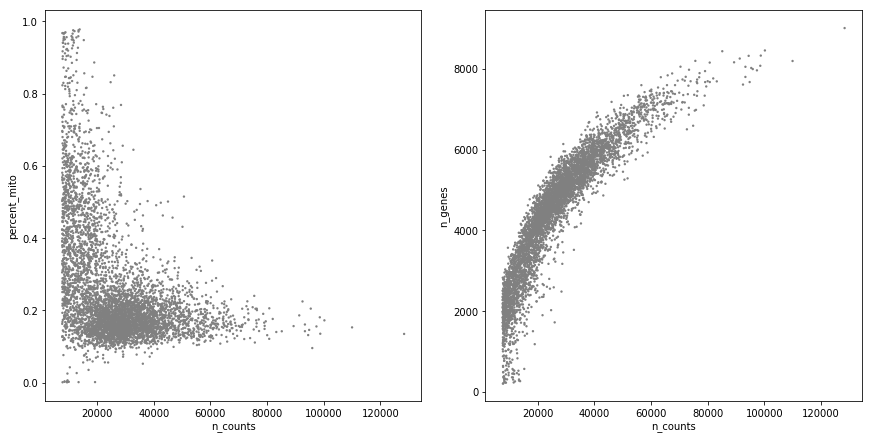

In [5]:
fig, axs = plt.subplots(1,2, figsize=(12,6),constrained_layout=True)
sc.pl.scatter(scanpy_obj, x='n_counts', y='percent_mito', ax=axs[0], show=False)
sc.pl.scatter(scanpy_obj, x='n_counts', y='n_genes', ax=axs[1], show=False)
plt.show()

In [6]:
# filter based on plots above
scanpy_obj = scanpy_obj[scanpy_obj.obs.n_genes < 7000, :]
scanpy_obj = scanpy_obj[scanpy_obj.obs.percent_mito < 0.25, :]

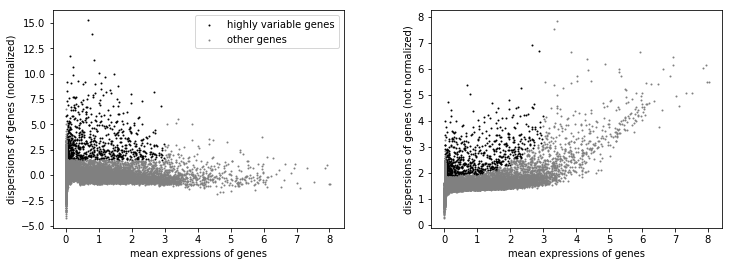

In [7]:
# Normalize to log TP10K
sc.pp.normalize_total(scanpy_obj, target_sum=1e5)
sc.pp.log1p(scanpy_obj)
scanpy_obj.raw = scanpy_obj

# Subset by highly variable genes
sc.pp.highly_variable_genes(scanpy_obj, min_mean=0.0125, max_mean=3, min_disp=1.5)
sc.pl.highly_variable_genes(scanpy_obj)

In [8]:
scanpy_obj = scanpy_obj[:, scanpy_obj.var.highly_variable]

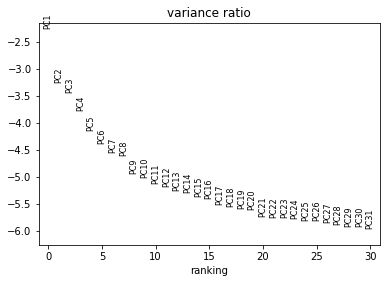

In [9]:
#sc.pp.regress_out(scanpy_obj, ['n_counts', 'percent_mito'])
sc.pp.scale(scanpy_obj, max_value=10)
sc.tl.pca(scanpy_obj, svd_solver='arpack')
sc.pl.pca_variance_ratio(scanpy_obj, log=True)

In [10]:
sc.pp.neighbors(scanpy_obj, n_neighbors=10, n_pcs=30)

In [11]:
sc.tl.umap(scanpy_obj)

In [12]:
sc.tl.leiden(scanpy_obj, resolution=0.5)

### UMAP/tSNE

Color by cluster

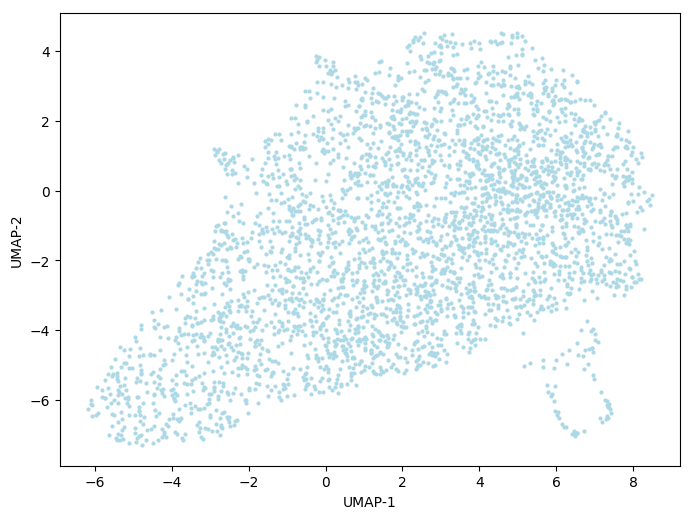

In [13]:
x = scanpy_obj.obsm['X_umap'][:, 0]
y = scanpy_obj.obsm['X_umap'][:, 1]

fig = plt.figure(figsize=(8,6), dpi=100)
ax = fig.add_subplot(111)
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')

p1 = ax.scatter(x,y, s=4,c='lightblue')

plt.show()

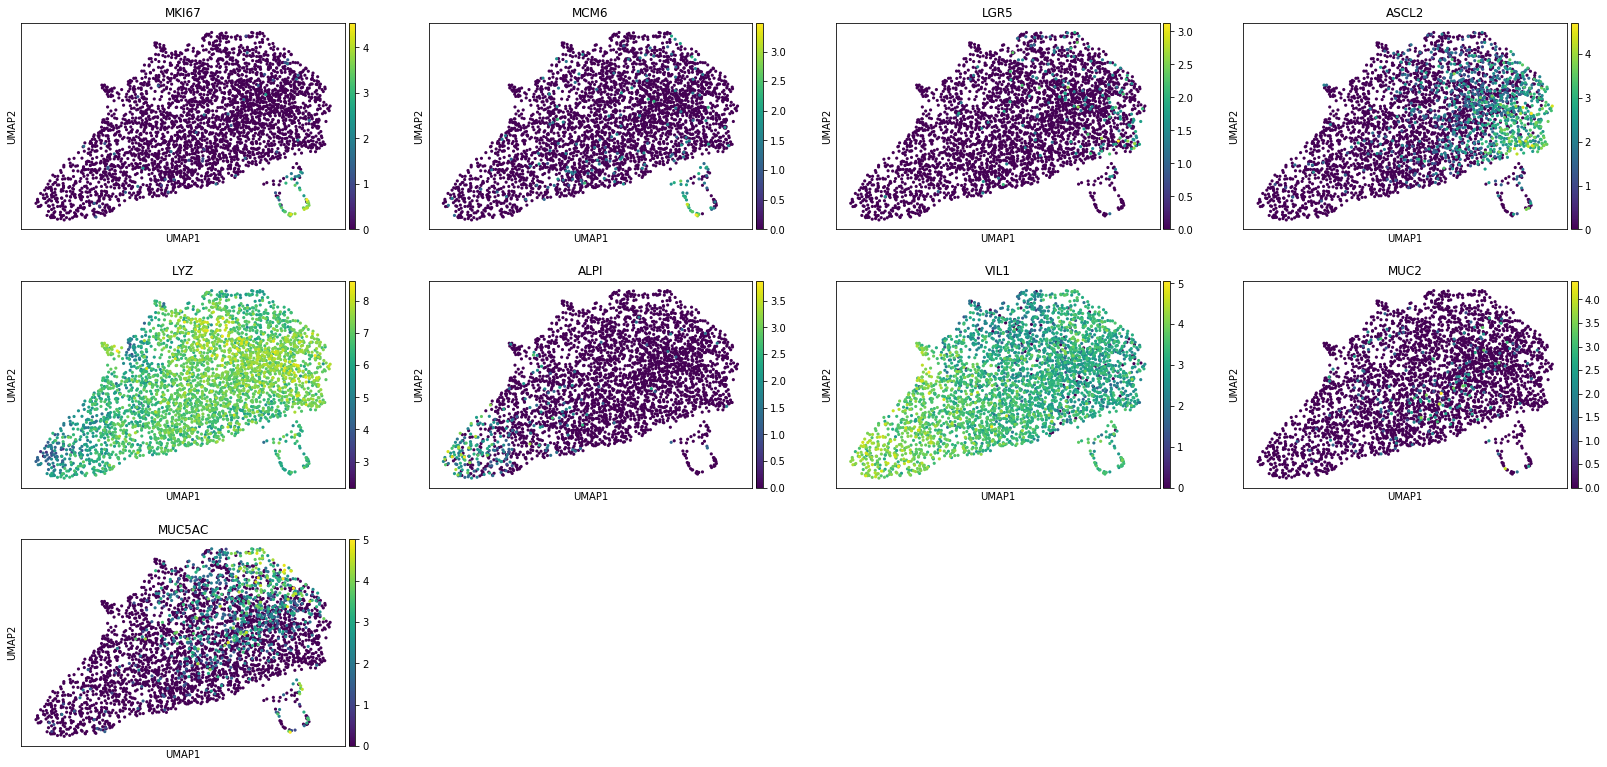

In [40]:
#sc.pl.umap(scanpy_obj, color=['LGR5','ASCL2','FTH1','LYZ','TFF3','S100A6','FABP1','FTL','EPCAM','CDH1','KRT19'], color_map='hot', size=40)
sc.pl.umap(scanpy_obj, color=['MKI67','MCM6','LGR5','ASCL2','LYZ','ALPI','VIL1','MUC2','MUC5AC'], size=40)

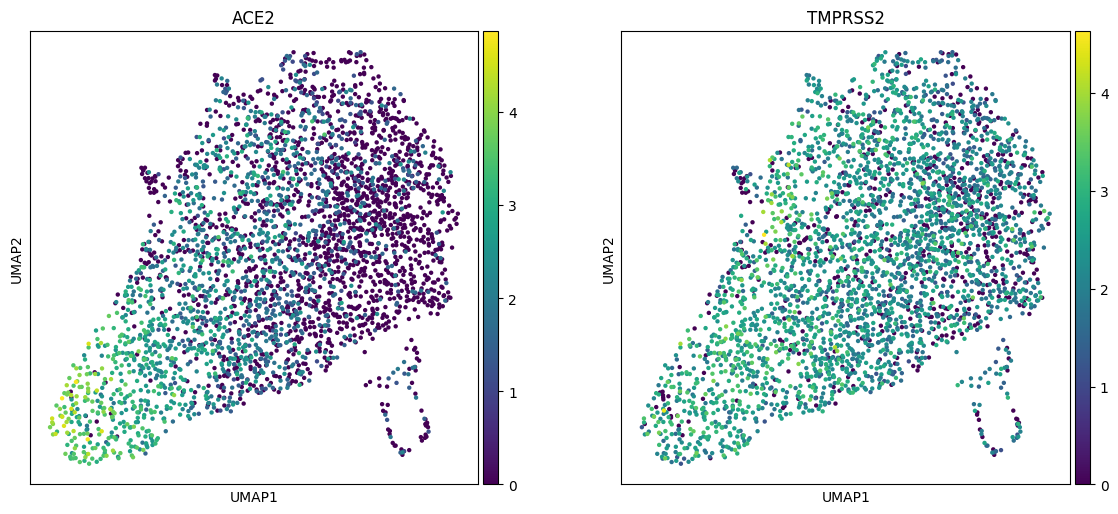

In [57]:
fig, ax = plt.subplots(1,2,figsize=(14,6), dpi=100)
sc.pl.umap(scanpy_obj, color=['ACE2'], size=40, show=False, ax=ax[0])
sc.pl.umap(scanpy_obj, color=['TMPRSS2'], size=40, show=False, ax=ax[1])
plt.show()

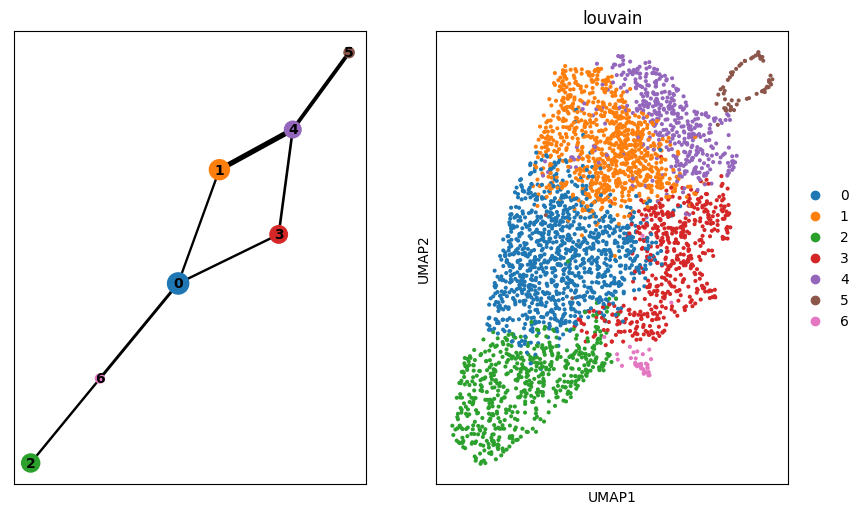

In [39]:
fig, axs = plt.subplots(1,2, figsize=(10,6), dpi=100)

sc.tl.paga(scanpy_obj)
sc.pl.paga(scanpy_obj, threshold=0.22, show=False, ax=axs[0])
#sc.tl.draw_graph(scanpy_obj, init_pos='paga')
#sc.pl.draw_graph(scanpy_obj, color='louvain', show=False, ax=axs[1])
sc.tl.umap(scanpy_obj, init_pos='paga')
sc.pl.umap(scanpy_obj, color='louvain', show=False, ax=axs[1])
plt.show()

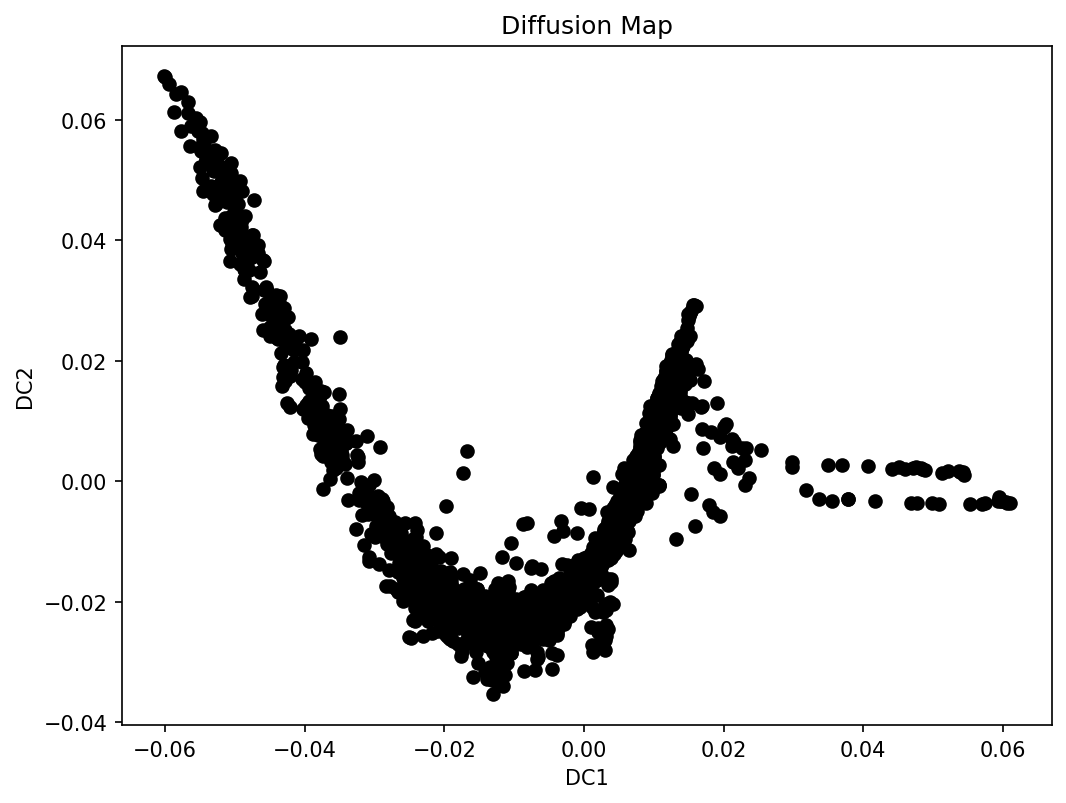

In [53]:
sc.tl.diffmap(scanpy_obj)
x = scanpy_obj.obsm['X_diffmap'][:, 1]
y = scanpy_obj.obsm['X_diffmap'][:, 2]
z = scanpy_obj.obsm['X_diffmap'][:, 3]

fig = plt.figure(figsize=(8,6), dpi=150)
ax = fig.add_subplot(111)
ax.set_xlabel('DC1')
ax.set_ylabel('DC2')
#ax.set_zlabel('DC3')
ax.set_title('Diffusion Map')
p1 = ax.scatter(x,z , c = 'black')

plt.show()

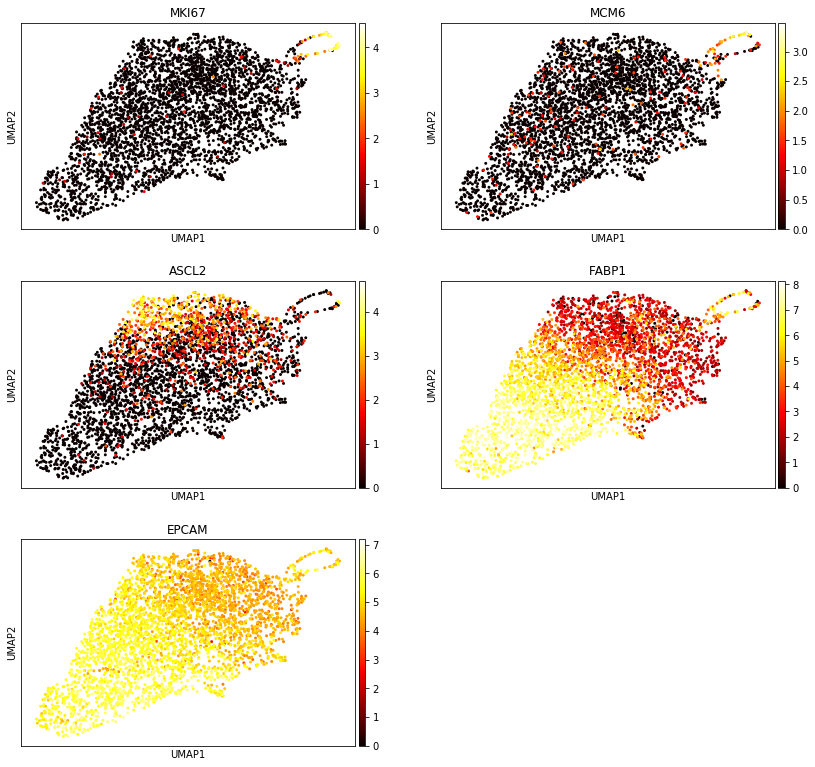

In [40]:
#sc.pl.draw_graph(scanpy_obj, color=['MKI67','MCM6','ASCL2','FABP1','EPCAM'], ncols=3, color_map='hot', size=40)
sc.pl.umap(scanpy_obj, color=['MKI67','MCM6','ASCL2','FABP1','EPCAM'], color_map='hot', ncols=2)

In [42]:
cell_max_mki67 = np.argmax(scanpy_obj.X[:, np.where(scanpy_obj.var.index == 'MKI67')])
scanpy_obj.uns['iroot'] = cell_max_mki67

In [43]:
sc.tl.dpt(scanpy_obj)

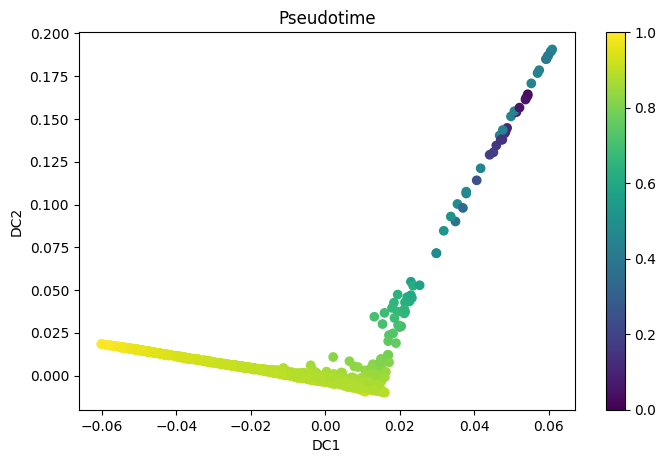

In [67]:

x = scanpy_obj.obsm['X_diffmap'][:, 1]
y = scanpy_obj.obsm['X_diffmap'][:, 2]
z = scanpy_obj.obsm['X_diffmap'][:, 3]
dpt = scanpy_obj.obs['dpt_pseudotime'].values

fig = plt.figure(figsize=(8,5), dpi=100)
ax = fig.add_subplot(111)
ax.set_xlabel('DC1')
ax.set_ylabel('DC2')
#ax.set_zlabel('DC3')
ax.set_title('Pseudotime')

p1 = ax.scatter(x,y, c = dpt)
fig.colorbar(p1)

plt.show()

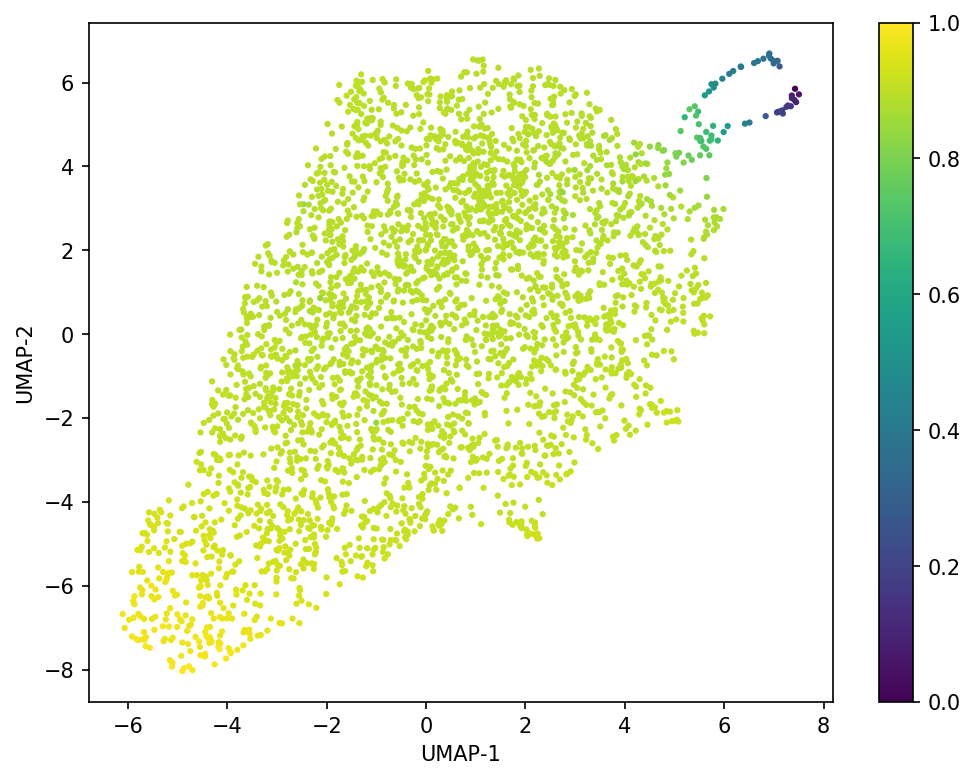

In [45]:
x = scanpy_obj.obsm['X_umap'][:, 0]
y = scanpy_obj.obsm['X_umap'][:, 1]
dpt = scanpy_obj.obs['dpt_pseudotime'].values

fig = plt.figure(figsize=(8,6), dpi=150)
ax = fig.add_subplot(111)
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')

p1 = ax.scatter(x,y, s=4,c=dpt)
plt.colorbar(p1)
plt.show()

## RNA Velocity

Load spliced/unspliced matrix files

In [530]:
FILE_10X_splice = '../scRNA-seq/AB-HE-BAS-1/output/AB-HE-BAS-1_Solo.out/Velocyto/raw/spliced/'
FILE_10X_unsplice = '../scRNA-seq/AB-HE-BAS-1/output/AB-HE-BAS-1_Solo.out/Velocyto/raw/unspliced/'

In [531]:
anndata_splice = sc.read_10x_mtx(FILE_10X_splice)
anndata_splice.var_names_make_unique(join='-')

anndata_unsplice = sc.read_10x_mtx(FILE_10X_unsplice)
anndata_unsplice.var_names_make_unique(join='-')

In [532]:
anndata_splice = anndata_splice[scanpy_obj.obs.index, scanpy_obj.var.index]
anndata_unsplice = anndata_unsplice[scanpy_obj.obs.index, scanpy_obj.var.index]

In [533]:

scanpy_obj.layers['spliced'] = anndata_splice.X
scanpy_obj.layers['unspliced'] = anndata_unsplice.X


In [534]:
scv.utils.show_proportions(scanpy_obj)

Abundance of ['spliced', 'unspliced']: [0.79 0.21]


In [535]:
scv.pp.filter_and_normalize(scanpy_obj, min_shared_counts=10)

Normalized count data: spliced, unspliced.


In [544]:
scv.pp.moments(scanpy_obj, n_pcs=20, n_neighbors=30)

computing neighbors
    finished (0:00:00) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)


In [545]:
scv.tl.velocity(scanpy_obj)


computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [546]:
scv.tl.velocity_graph(scanpy_obj)


computing velocity graph
    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_draw_graph_fa', embedded velocity vectors (adata.obsm)


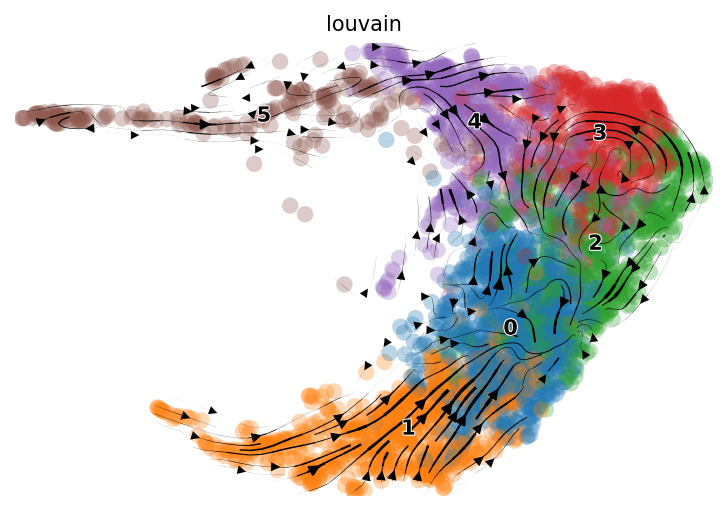

In [547]:

fig, axs = plt.subplots(1,1, dpi=150)
scv.pl.velocity_embedding_stream(scanpy_obj, basis='X_draw_graph_fa',ax=axs,show=False)
plt.show()
